## Red neuronal recurrente desde cero.

Fuente: https://www.analyticsvidhya.com/blog/2019/01/fundamentals-deep-learning-recurrent-neural-networks-scratch-python/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

### Generamos una "serie de tiempo"

In [2]:
sin_wave = np.array([math.sin(x) for x in np.arange(200)]) + np.random.rand(200)

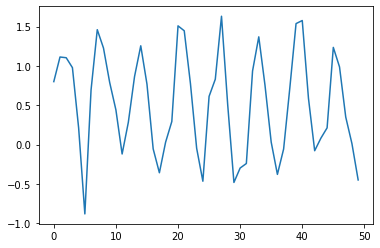

In [3]:
plt.plot(sin_wave[:50])

In [4]:
len(sin_wave), sin_wave.shape

(200, (200,))

### Guardamos algunos intervalos de tiempo X(t)

In [5]:
X = []
Y = []

seq_len = 50
num_records = len(sin_wave) - seq_len #150

for i in range(num_records - 50): #100
    X.append(sin_wave[i:i+seq_len])
    Y.append(sin_wave[i+seq_len])
    print("it: {} | X:{} | Y:{}".format(i, X[i], Y[i]))
    
X = np.array(X)
X = np.expand_dims(X, axis=2)

Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)

it: 0 | X:[ 0.80031917  1.11350399  1.10420108  0.97794932  0.21098548 -0.88250471
  0.69530491  1.46108017  1.22743181  0.78858135  0.44047611 -0.12013028
  0.28275475  0.86507     1.25602831  0.76829998 -0.05522108 -0.35883397
  0.02996308  0.2928577   1.50950468  1.44709161  0.77465073 -0.04800718
 -0.46664822  0.61270782  0.83049569  1.63197198  0.50342516 -0.48224908
 -0.29885359 -0.24145031  0.93620328  1.36985849  0.75523056  0.03101708
 -0.37962475 -0.05711169  0.72088504  1.53834335  1.57741083  0.58837628
 -0.07864472  0.0809315   0.21211268  1.23573514  0.9873593   0.35019503
  0.0112244  -0.45049946] | Y:-0.20546076850550365
it: 1 | X:[ 1.11350399  1.10420108  0.97794932  0.21098548 -0.88250471  0.69530491
  1.46108017  1.22743181  0.78858135  0.44047611 -0.12013028  0.28275475
  0.86507     1.25602831  0.76829998 -0.05522108 -0.35883397  0.02996308
  0.2928577   1.50950468  1.44709161  0.77465073 -0.04800718 -0.46664822
  0.61270782  0.83049569  1.63197198  0.50342516 -0.4

In [6]:
X.shape, Y.shape

((100, 50, 1), (100, 1))

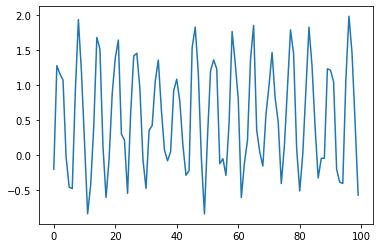

In [7]:
plt.plot(Y)

### Creamos un conjunto de validación

In [8]:
X_val = []
Y_val = []

for i in range(num_records - 50, num_records):
    X_val.append(sin_wave[i:i+seq_len])
    Y_val.append(sin_wave[i+seq_len])
    print("it: {} | X:{} | Y:{}".format(i, X_val[i-100], Y_val[i-100]))
    
X_val = np.array(X_val)
X_val = np.expand_dims(X_val, axis=2)

Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis=1)

it: 100 | X:[ 0.25803271  1.20255509  1.3547684   1.22744854 -0.12818262 -0.05608011
 -0.29358929  0.43771256  1.76074461  1.31653542  0.79560262 -0.61128742
 -0.12244694  0.20543917  1.37161244  1.84713362  0.35253731  0.0355375
 -0.16073547  0.56547421  0.98768666  1.46171265  0.81339744  0.46445039
 -0.41101026  0.12481083  0.94948627  1.78303342  1.44444664  0.08216719
 -0.51694233  0.02094508  0.92520704  1.82195692  1.26429004  0.39000044
 -0.33214841 -0.05117899 -0.04944386  1.22796412  1.20774496  1.04665652
 -0.20642606 -0.39226905 -0.4090939   1.07434557  1.9786013   1.45738086
  0.46807237 -0.57716998] | Y:-0.5696208745911923
it: 101 | X:[ 1.20255509  1.3547684   1.22744854 -0.12818262 -0.05608011 -0.29358929
  0.43771256  1.76074461  1.31653542  0.79560262 -0.61128742 -0.12244694
  0.20543917  1.37161244  1.84713362  0.35253731  0.0355375  -0.16073547
  0.56547421  0.98768666  1.46171265  0.81339744  0.46445039 -0.41101026
  0.12481083  0.94948627  1.78303342  1.44444664  0

## Arquitectura de la RNN

In [9]:
learning_rate = 0.0001    
nepoch = 25               
T = 50                   # largo de la secuencia
hidden_dim = 100         
output_dim = 1

bptt_truncate = 5
min_clip_value = -10
max_clip_value = 10

### Matrices de Pesos:

 - U es la matriz de pesos para los pesos entre la entrada y las capas ocultas.
 - V es la matriz de pesos para los pesos entre las capas ocultas y las de salida.
 - W es la matriz de pesos para los pesos compartidos en la capa oculta, la capa recurrente propia de las RNNs.

In [10]:
U = np.random.uniform(0, 1, (hidden_dim, T))
V = np.random.uniform(0, 1, (output_dim, hidden_dim))
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))

### Función de activación:

In [11]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

### Entrenamiento
```
for epocas 
    for secuence in Y
        for element in secuence
```

In [12]:
for epoch in range(nepoch):
    # check loss on train
    loss = 0.0    
    # do a forward pass to get prediction
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]                    # get input, output values of each record
        prev_s = np.zeros((hidden_dim, 1))   # here, prev-s is the value of the previous activation of hidden layer; which is initialized as all zeroes
        for t in range(T):
            new_input = np.zeros(x.shape)    # we then do a forward pass for every timestep in the sequence
            new_input[t] = x[t]              # for this, we define a single input for that timestep
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

    # calculate error 
        loss_per_record = (y - mulv)**2 / 2
        loss += loss_per_record
    loss = loss / float(y.shape[0])
    
    # check loss on val
    val_loss = 0.0
    for i in range(Y_val.shape[0]):
        x, y = X_val[i], Y_val[i]
        prev_s = np.zeros((hidden_dim, 1))
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

        loss_per_record = (y - mulv)**2 / 2
        val_loss += loss_per_record
    val_loss = val_loss / float(y.shape[0])

    print('Epoch: ', epoch + 1, ', Loss: ', loss, ', Val Loss: ', val_loss)
    
    # train model
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]
    
        layers = []
        prev_s = np.zeros((hidden_dim, 1))
        dU = np.zeros(U.shape)
        dV = np.zeros(V.shape)
        dW = np.zeros(W.shape)
        
        dU_t = np.zeros(U.shape)
        dV_t = np.zeros(V.shape)
        dW_t = np.zeros(W.shape)
        
        dU_i = np.zeros(U.shape)
        dW_i = np.zeros(W.shape)
        
        # forward pass
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            layers.append({'s':s, 'prev_s':prev_s})
            prev_s = s
            
        # derivative of pred
        dmulv = (mulv - y)
        
        # backward pass
        for t in range(T):
            dV_t = np.dot(dmulv, np.transpose(layers[t]['s']))
            dsv = np.dot(np.transpose(V), dmulv)
            
            ds = dsv
            dadd = add * (1 - add) * ds
            
            dmulw = dadd * np.ones_like(mulw)

            dprev_s = np.dot(np.transpose(W), dmulw)


            for i in range(t-1, max(-1, t-bptt_truncate-1), -1):
                ds = dsv + dprev_s
                dadd = add * (1 - add) * ds

                dmulw = dadd * np.ones_like(mulw)
                dmulu = dadd * np.ones_like(mulu)

                dW_i = np.dot(W, layers[t]['prev_s'])
                dprev_s = np.dot(np.transpose(W), dmulw)

                new_input = np.zeros(x.shape)
                new_input[t] = x[t]
                dU_i = np.dot(U, new_input)
                dx = np.dot(np.transpose(U), dmulu)

                dU_t += dU_i
                dW_t += dW_i
                
            dV += dV_t
            dU += dU_t
            dW += dW_t
            
            if dU.max() > max_clip_value:
                dU[dU > max_clip_value] = max_clip_value
            if dV.max() > max_clip_value:
                dV[dV > max_clip_value] = max_clip_value
            if dW.max() > max_clip_value:
                dW[dW > max_clip_value] = max_clip_value
                
            
            if dU.min() < min_clip_value:
                dU[dU < min_clip_value] = min_clip_value
            if dV.min() < min_clip_value:
                dV[dV < min_clip_value] = min_clip_value
            if dW.min() < min_clip_value:
                dW[dW < min_clip_value] = min_clip_value
        
        # update
        U -= learning_rate * dU
        V -= learning_rate * dV
        W -= learning_rate * dW

Epoch:  1 , Loss:  [[111773.33570661]] , Val Loss:  [[55918.2564873]]
Epoch:  2 , Loss:  [[69498.72096367]] , Val Loss:  [[34774.77408077]]
Epoch:  3 , Loss:  [[37224.10622026]] , Val Loss:  [[18631.29167401]]
Epoch:  4 , Loss:  [[14949.48626181]] , Val Loss:  [[7487.80662066]]
Epoch:  5 , Loss:  [[2641.01182329]] , Val Loss:  [[1327.21958119]]
Epoch:  6 , Loss:  [[32.81803499]] , Val Loss:  [[19.29085009]]
Epoch:  7 , Loss:  [[36.06197264]] , Val Loss:  [[21.44819231]]
Epoch:  8 , Loss:  [[36.50588986]] , Val Loss:  [[21.6961803]]
Epoch:  9 , Loss:  [[36.90654971]] , Val Loss:  [[21.93649185]]
Epoch:  10 , Loss:  [[36.88192014]] , Val Loss:  [[21.9149273]]
Epoch:  11 , Loss:  [[36.74399643]] , Val Loss:  [[21.85418994]]
Epoch:  12 , Loss:  [[37.21018091]] , Val Loss:  [[22.16391399]]
Epoch:  13 , Loss:  [[36.78269536]] , Val Loss:  [[21.89803108]]
Epoch:  14 , Loss:  [[36.81566527]] , Val Loss:  [[21.8900895]]
Epoch:  15 , Loss:  [[36.96691425]] , Val Loss:  [[21.99754276]]
Epoch:  16

In [13]:
preds = []
for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
    prev_s = np.zeros((hidden_dim, 1))
    # Forward pass
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

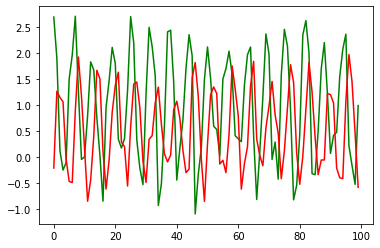

In [14]:
plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y[:, 0], 'r')
plt.show()

### Ahora en el conjunto de validación

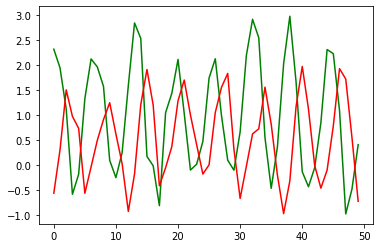

In [15]:
preds = []
for i in range(Y_val.shape[0]):
    x, y = X_val[i], Y_val[i]
    prev_s = np.zeros((hidden_dim, 1))
    # For each time step...
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y_val[:, 0], 'r')
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error

mean_squared_error(Y_val[:, 0], preds[:, 0, 0])

2.5566364688971